In [1]:
import Post_Donors_PreProcess

In [2]:
import GPy
import GPyOpt
import numpy as np

In [3]:
import lightgbm as lgbm
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

In [4]:
#Post_Donor_PrePro : Preprocessing function that pulls from the original data
#Diet : Pull from a previously saved preprocessed csv, as to only do scaling and text processing

In [5]:
X, y, df_cols, le_dict = Post_Donors_PreProcess.Diet_Prepro(
                            Tf_Features=1500, 
                            One_Hot=False, 
                            Standard_Scale=True,
                            Force=True)

Encoding
Scaling
Text Processing
Tfidf


In [6]:
#lgbm_train_data = lgbm.Dataset(data=X,label=y)

In [7]:
y.value_counts(normalize=True)

1    0.596761
0    0.403239
Name: Project Current Status, dtype: float64

## Default

In [58]:
X_train, X_test, y_train, y_test = train_test_split(X,y)

In [59]:
model = lgbm.LGBMClassifier()
model.fit(X_train,y_train)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        learning_rate=0.1, max_depth=-1, min_child_samples=20,
        min_child_weight=0.001, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=31, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

In [60]:
roc_auc_score(y_test,model.predict(X_test))

 C:\Users\Namae\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning:The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


0.6749947118836401

## Random Search

In [61]:
from sklearn.model_selection import RandomizedSearchCV

In [62]:
model = lgbm.LGBMClassifier(
    application= 'binary',
    learning_rate= 0.01,
    scale_pos_weight= 2,
    drop_rate= 0.2,)

In [63]:
params_rand2 = {'n_estimators': [x for x in range(50,200,20)],
             'feature_fraction': [x / 1000.0 for x in range(500,900,20)],
             'bagging_fraction': [x / 1000.0 for x in range(500,900,20)],
             'lambda_l2' : [x / 100.0 for x in range(0,310,10)],
             'boosting_type': ['dart','gbdt']}

In [64]:
rs = RandomizedSearchCV(
    model, 
    params_rand2, 
    n_iter=5,
    scoring='roc_auc',
    cv=5)

rs.fit(X,y)

RandomizedSearchCV(cv=5, error_score='raise',
          estimator=LGBMClassifier(application='binary', boosting_type='gbdt', class_weight=None,
        colsample_bytree=1.0, drop_rate=0.2, learning_rate=0.01,
        max_depth=-1, min_child_samples=20, min_child_weight=0.001,
        min_split_gain=0.0, n_estimators=100, n_jobs=-1, num_leaves=31,
        objective=None, random_state=None, reg_alpha=0.0, reg_lambda=0.0,
        scale_pos_weight=2, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0),
          fit_params=None, iid=True, n_iter=5, n_jobs=1,
          param_distributions={'n_estimators': [50, 70, 90, 110, 130, 150, 170, 190], 'feature_fraction': [0.5, 0.52, 0.54, 0.56, 0.58, 0.6, 0.62, 0.64, 0.66, 0.68, 0.7, 0.72, 0.74, 0.76, 0.78, 0.8, 0.82, 0.84, 0.86, 0.88], 'bagging_fraction': [0.5, 0.52, 0.54, 0.56, 0.58, 0.6, 0.62, 0.64, 0.66, 0.68, 0.7, 0....1.8, 1.9, 2.0, 2.1, 2.2, 2.3, 2.4, 2.5, 2.6, 2.7, 2.8, 2.9, 3.0], 'boosting_type': ['dart', 'gbdt'

In [65]:
rs.best_score_

0.7267717156189221

In [66]:
rs.best_params_

{'n_estimators': 190,
 'lambda_l2': 2.5,
 'feature_fraction': 0.84,
 'boosting_type': 'dart',
 'bagging_fraction': 0.6}

In [67]:
del model, rs, X_train, X_test, y_train, y_test, RandomizedSearchCV

## Bay Search

In [8]:
params_bay = [{'name': 'feature_fraction','type': 'continuous', 'domain': (500,900)},
              {'name': 'bagging_fraction','type': 'continuous', 'domain': (500,900)},
              {'name': 'lambda_l2',       'type': 'continuous', 'domain': (100,500)},
              {'name': 'n_estimators',      'type': 'continuous', 'domain': (200,600)}]

In [9]:
def Bay_Wrapper(x):
    """
    Model Wrapper for Bay Opt 
    Wrapper used for LGBM & Bay:
    x[0][:] = list of all params for this aq
    """
    AUC = True
    if AUC: metric = 'auc'
    else: metric = 'binary_logloss'
    
    lgbm_params = { 'feature_fraction': x[0][0]/1000,
                    'bagging_fraction': x[0][1]/1000,
                    'lambda_l2' : x[0][2]/1000,
                    'boosting': 'gbdt',
                    'n_estimators' : int(x[0][3]),
                   
                    'application': 'binary',
                    'learning_rate': 0.01,
                    'scale_pos_weight': 2,
                    'drop_rate': 0.2,
}

    cv_results = lgbm.cv(train_set=lgbm.Dataset(data=X,label=y),
                         params=lgbm_params, 
                         nfold=5,
                         num_boost_round = 600,
                         early_stopping_rounds=50,
                         metrics=[metric])

    optimum_boost_rounds = np.argmax(cv_results[metric+'-mean'])
    print('{} : {}'.format(metric,np.max(cv_results['{}-mean'.format(metric)])))
    
    return np.max(cv_results[metric+'-mean'])

In [10]:
bay = GPyOpt.methods.BayesianOptimization(Bay_Wrapper,
                              params_bay,
                              acquisition_type ='EI',   # LCB acquisition
                              acquisition_weight = .5,  # Exploration exploitation
                              maximize=True)

auc : 0.762124735045052
auc : 0.7459914683793223
auc : 0.7442246903264309
auc : 0.7540604744752623
auc : 0.7563135588348209


In [11]:
bay.run_optimization(5) #GPyOpt uses 5 points + the number listed
print('Function after 5 Aquisitions')
bay.plot_acquisition()

auc : 0.7566104481775701
auc : 0.7483193561208304
auc : 0.7598376554458268
auc : 0.7479742900598307
auc : 0.762234824764042
Function after 5 Aquisitions


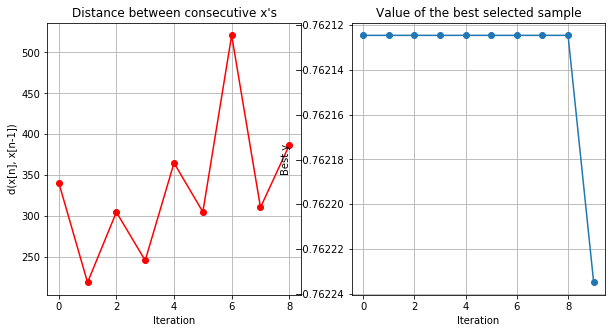

In [12]:
bay.plot_convergence()

In [13]:
bay.plot_acquisition()

In [14]:
bay_pred = bay.x_opt
print('feature_fraction: '+str(round(bay_pred[0]/1000,5)))
print('bagging_fraction: '+str(round(bay_pred[1]/1000,5)))
print('lambda_l2: '+str(round(bay_pred[2]/1000,5)))
print('n_estimators: '+str(round(bay_pred[3],5)))

feature_fraction: 0.8542
bagging_fraction: 0.68494
lambda_l2: 0.45955
n_estimators: 548.28682


auc : 0.7610107617663138
auc : 0.7556926339340044
auc : 0.7604007194441282
auc : 0.7617931203902224
auc : 0.7615878157967699
auc : 0.7622411906738544
auc : 0.7627860329166447
auc : 0.7624575964054815
auc : 0.7617751111773342
auc : 0.761470334184215
auc : 0.7609625856997926
auc : 0.7623414949492184
auc : 0.7623066447258543
auc : 0.7609451225501687
auc : 0.7610386426557951
auc : 0.7610718034377608
auc : 0.7633520713025186
auc : 0.7626745254530599
auc : 0.7633059355798644
auc : 0.7630926210400719


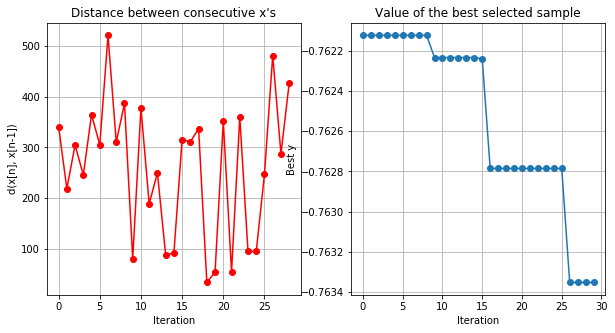

In [15]:
bay.run_optimization(20)
bay.plot_convergence()
bay.plot_acquisition()

In [25]:
bay_pred = bay.x_opt
print('feature_fraction: '+str(round(bay_pred[0]/1000,5)))
print('bagging_fraction: '+str(round(bay_pred[1]/1000,5)))
print('lambda_l2: '+str(round(bay_pred[2]/1000,5)))
print('n_estimators: '+str(round(bay_pred[3],5)))

feature_fraction: 0.70333
bagging_fraction: 0.79624
lambda_l2: 0.5
n_estimators: 600.0


In [26]:
final_params = {'feature_fraction': bay_pred[0]/1000,
                'bagging_fraction': bay_pred[1]/1000,
                'lambda_l2' : bay_pred[2]/1000,
                'boosting': 'gbdt',
                'n_estimators' : int(bay_pred[3]),
                   
                'application': 'binary',
                'learning_rate': 0.01,
                'scale_pos_weight': 2,
                'drop_rate': 0.2,
                'metric':'auc'}

 ## Final

In [27]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y)

In [28]:
model = lgbm.train(params=final_params,
                train_set=lgbm.Dataset(X_train,y_train),
                valid_sets=lgbm.Dataset(X_test,y_test),
                num_boost_round=600,
                early_stopping_rounds=50,
                verbose_eval=False)

In [29]:
roc_auc_score(y_test,model.predict(X_test))

0.7574230427071948

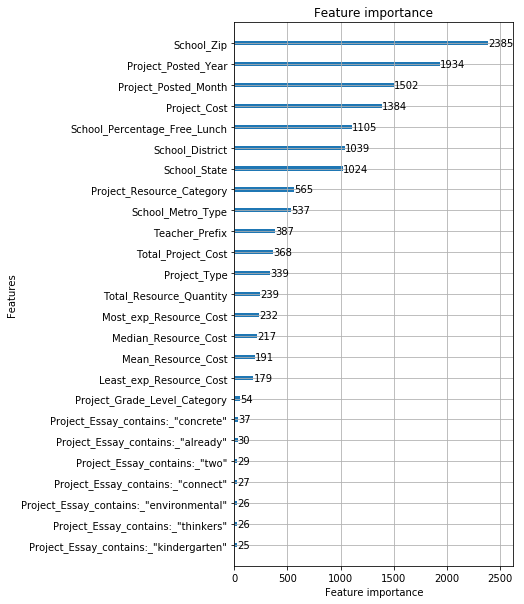

In [30]:
lgbm.plot_importance(model,max_num_features=25,figsize=(5,10));

In [31]:
model.feature_importance()

array([339,  54, 565, ...,   0,   1,   0])

In [32]:
# save model to file
model.save_model('model.txt')

In [34]:
import pandas as pd

In [38]:
f_importance = pd.DataFrame({'Feature':model.feature_name(),
                             'Importance':model.feature_importance()})

In [40]:
f_importance.to_csv('Importance.csv')